[< 04 - Time and Chronology](04%20-%20Time%20and%20Chronology.ipynb) | [Home](https://github.com/harrisonpim/bookworm) | [06 - Stable Roommates, Marriages, and Gender >](06%20-%20Stable%20Roommates%2C%20Marriages%2C%20and%20Gender.ipynb)  

# Cliques and Communities

In [5]:
from bookworm import *

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,9)

import pandas as pd
import numpy as np
import networkx as nx

Communities are just as important in the social structure of novels as they are in real-world social structures. They're also just as obvious - it's easy to think of a tight cluster of characters in your favourite novel which are isolated from the rest of the story. Visually, they're also quite apparent. Refer back to the Dursley's little clique which we saw back in [notebook 3](./03%20-%20Visualising%20and%20Analysing%20Networks.ipynb).
However, NetworkX's clique finding algorithm isn't ideal - it enumerates _all_ cliques, giving us plenty of overlapping cliques which aren't that descriptive of the existing communities. In mathematical terms, we want to maximise the modularity of the whole graph at once.

A cleaner solution to our problem is the python implementation of louvain community detection given [here](https://github.com/taynaud/python-louvain) by Thomas Aynaud. 

In [6]:
import community

This implementation of louvain modularity is a very smart piece of maths, first given by Blondel et al in [Fast unfolding of communities in large networks](https://arxiv.org/pdf/0803.0476.pdf). If you're not a mathematical reader, just skip over this section and go straight to the results.  
If you are interested in the maths, it goes roughly like this:

We want to calculate a value Q between -1 and 1 for a partition of our graph, where $Q$ denotes the _modularity_ of the network. Modularity is a comparative measure of the density _within_ the communities in question and the density _between_ them. A high modularity indicates a good splitting. Through successive, gradual changes to our labelling of nodes and close monitoring of the value of $Q$, we can optimise our partition(s). $Q$ and its change for each successve optimisation epoch ($\Delta Q$) are calculated in two stages, as follows.

$$
Q = \frac{1}{2m} \sum_{ij} \left[\ A_{ij}\ \frac{k_i k_j}{2m}\ \right]\ \delta(c_i, c_j)
$$

- $m$ is the sum of all of the edge weights in the graph
- $A_{ij}$ represents the edge weight between nodes $i$ and $j$
- $k_{i}$ and $k_{j}$ are the sum of the weights of the edges attached to nodes $i$ and $j$, respectively
- $\delta$ is the delta function.
- $c_{i}$ and $c_{j}$ are the communities of the nodes

First, each node in the network is assigned to its own community. Then for each node $i$, the change in modularity is calculated by removing $i$ from its own community and moving it into the community of each neighbor $j$ of $i$:

$$
\Delta Q = \left[\frac{\sum_{in} +\ k_{i,in}}{2m} - \left(\frac{\sum_{tot} +\ k_{i}}{2m}\right)^2 \right] - 
\left[ \frac{\sum_{in}}{2m} - \left(\frac{\sum_{tot}}{2m}\right)^2 - \left(\frac{k_{i}}{2m}\right)^2 \right]
$$

- $\sum_{in}$ is sum of all the weights of the links inside the community $i$ is moving into
- $k_{i,in}$ is the sum of the weights of the links between $i$ and other nodes in the community
- $m$ is the sum of the weights of all links in the network
- $\Sigma _{tot}$ is the sum of all the weights of the links to nodes in the community
- $k_{i}$ is the weighted degree of $i$

Once this value is calculated for all communities that $i$ is connected to, $i$ is placed into the community that resulted in the greatest modularity increase. If no increase is possible, $i$ remains in its original community. This process is applied repeatedly and sequentially to all nodes until no modularity increase can occur. Once this local maximum of modularity is hit, we move on to the second stage.

All of the nodes in the same community are grouped to create a new network, where nodes are the communities from the previous phase. Links between nodes within communities are represented by self loops on these new _community nodes_, and links from multiple nodes in the same community to a node in a different community are represented by weighted edges. The first stage is then applied to this new weighted network, and the process repeats.

### Actually doing the thing
Let's load in a book and try applying `python-louvain`'s implementation of this algorithm to it:

In [7]:
book = nx.from_pandas_dataframe(bookworm('data/raw/hp_chamber_of_secrets.txt'),
                                source='source',
                                target='target')

/home/harrisonpim/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/harrisonpim/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/harrisonpim/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/harrisonpim/anaconda3/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnin

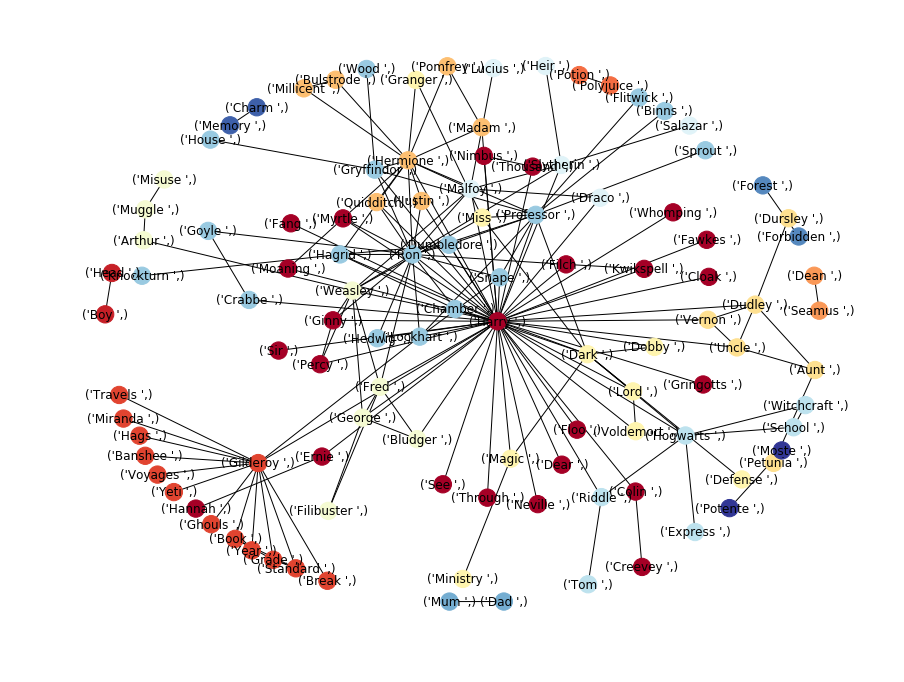

In [8]:
partitions = community.best_partition(book)
values = [partitions.get(node) for node in book.nodes()]

nx.draw(book,
        cmap=plt.get_cmap("RdYlBu"),
        node_color=values,
        with_labels=True)

Sweet - that works nicely. We can wrap this up neatly into a single function call

In [9]:
def draw_with_communities(book):
    '''
    draw a networkx graph with communities partitioned and coloured 
    according to their louvain modularity
    
    Parameters
    ----------
    book : nx.Graph (required)
        the book graph to be visualised
    '''
    partitions = community.best_partition(book)
    values = [partitions.get(node) for node in book.nodes()]

    nx.draw(book,
            cmap=plt.get_cmap("RdYlBu"),
            node_color=values,
            with_labels=True)

In [10]:
book = nx.from_pandas_dataframe(bookworm('data/raw/fellowship_of_the_ring.txt'),
                                source='source',
                                target='target')

/home/harrisonpim/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/harrisonpim/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/harrisonpim/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/harrisonpim/anaconda3/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnin

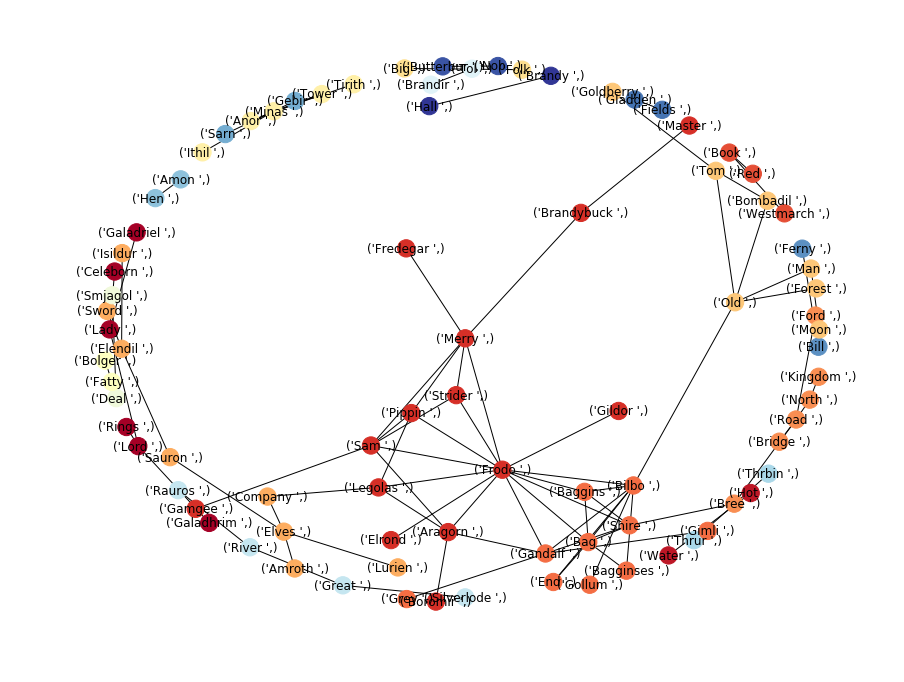

In [11]:
draw_with_communities(book)

[< 04 - Time and Chronology](04%20-%20Time%20and%20Chronology.ipynb) | [Home](https://github.com/harrisonpim/bookworm) | [06 - Stable Roommates, Marriages, and Gender >](06%20-%20Stable%20Roommates%2C%20Marriages%2C%20and%20Gender.ipynb)  